### MODULAR EDA + NLP NOTEBOOK CODE

In [14]:
# Register a post-run callback to print a short completion message after each executed code cell
from IPython import get_ipython
def _post_run_cell(result):
    try:
        status = 'OK' if getattr(result, 'success', True) else 'FAILED'
    except Exception:
        status = 'OK'
    print(f"[cell-complete] status={status}")
ip = get_ipython()
if ip:
    try:
        ip.events.register('post_run_cell', _post_run_cell)
        print('Post-run callback registered: will print [cell-complete] after each cell')
    except Exception as e:
        print('Could not register post-run callback:', e)


Post-run callback registered: will print [cell-complete] after each cell
[cell-complete] status=OK


In [15]:
# ============================================================
# MODULE IMPORTS
# ============================================================

import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import pytextrank
import nltk

# Initialize SpaCy + PyTextRank
nlp = spacy.load('en_core_web_sm')

#tr = pytextrank.TextRank()
nlp.add_pipe("textrank")

sns.set(style="whitegrid")


c:\Users\Jose\Desktop\KAIM8\WEEK1\programming\news-sentiment-stock-prediction\.venv\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[cell-complete] status=OK


### 1. DATA LOADING & CLEANING FUNCTIONS

In [5]:
# ============================================================
# DATA LOADING
# ============================================================

def load_dataset(path: str):
    """Loads CSV dataset."""
    data = pd.read_csv(path, index_col=0)
    print("Loaded dataset with shape:", data.shape)
    return data


# ============================================================
# DATA CLEANING
# ============================================================

def clean_headlines(df: pd.DataFrame):
    """Handles nulls, duplicates, ensures text format."""
    print("\n--- Null Counts Before Cleaning ---")
    print(df.isnull().sum())

    df = df.dropna(subset=['headline'])
    print("Remaining rows after dropping null headlines:", df.shape[0])

    dup = df.duplicated().sum()
    print("Duplicate rows:", dup)
    if dup > 0:
        df = df.drop_duplicates()

    df['headline'] = df['headline'].astype(str)
    return df


def prepare_dates(df: pd.DataFrame):
    """Converts 'date' to datetime & sets index."""
    if 'date' not in df.columns:
        print("⚠ No date column found.")
        return df
    
    df['date'] = pd.to_datetime(df['date'], utc=True, format="ISO8601")
    df = df.set_index('date')
    print("Date column converted & set as index.")
    return df


### 2. SENTIMENT ANALYSIS MODULE

In [6]:
# ============================================================
# SENTIMENT ANALYSIS
# ============================================================

def compute_sentiment(text: str) -> float:
    """Returns TextBlob sentiment polarity."""
    return TextBlob(text).sentiment.polarity


def sentiment_category(score):
    """Assigns category based on polarity."""
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    return "Neutral"


def apply_sentiment(df: pd.DataFrame, sample_size=200):
    """Applies sentiment analysis to a sample."""
    sample = df.head(sample_size).copy()
    sample['polarity'] = sample['headline'].apply(compute_sentiment)
    sample['category'] = sample['polarity'].apply(sentiment_category)
    return sample


def plot_sentiment_distribution(sample: pd.DataFrame):
    plt.figure(figsize=(6,4))
    sns.countplot(x=sample['category'], palette="viridis")
    plt.title("Sentiment Distribution")
    plt.show()


### 3. DESCRIPTIVE STATISTICS MODULE

In [ ]:
# ============================================================
# DESCRIPTIVE TEXT STATS
# ============================================================

def headline_statistics(df: pd.DataFrame):
    df['headline_length'] = df['headline'].apply(len)
    print("\n--- Headline Length Statistics ---")
    print(df['headline_length'].describe())

    plt.figure(figsize=(7,4))
    sns.histplot(df['headline_length'], bins=30)
    plt.title("Distribution of Headline Lengths")
    plt.show()


def publisher_statistics(df: pd.DataFrame):
    if 'publisher' not in df.columns:
        print("⚠ No publisher column found.")
        return
    
    counts = df['publisher'].value_counts()
    print("\n--- Publisher Frequency (Top 20) ---")
    print(counts.head(20))

    plt.figure(figsize=(10,4))
    counts.head(20).plot(kind='bar')
    plt.title("Top Publishers")
    plt.show()
    

def publisher_domain_analysis(df: pd.DataFrame):
    if 'publisher' not in df.columns:
        return
    
    def domain(p):
        return p.split('@')[-1] if '@' in p else p

    df['publisher_domain'] = df['publisher'].astype(str).apply(domain)

    domain_counts = df['publisher_domain'].value_counts()

    plt.figure(figsize=(10,4))
    domain_counts.head(15).plot(kind='bar')
    plt.title("Publisher Domains")
    plt.show()


### 4. TIME SERIES ANALYSIS MODULE

In [10]:
# ============================================================
# TIME SERIES ANALYSIS
# ============================================================

def publication_trends(df: pd.DataFrame):
    if not isinstance(df.index, pd.DatetimeIndex):
        print("⚠ Date index not set, skipping time-series analysis.")
        return

    daily = df.resample('D').size()

    plt.figure(figsize=(12,4))
    plt.plot(daily)
    plt.title("Daily Publication Frequency")
    plt.grid(True)
    plt.show()

    df['hour'] = df.index.hour
    plt.figure(figsize=(10,4))
    sns.countplot(x=df['hour'])
    plt.title("Hourly Publication Distribution")
    plt.show()


### 5. TOPIC / KEYWORD EXTRACTION MODULE

In [11]:
# ============================================================
# TOPIC MODELING / KEYWORDS
# ============================================================

def extract_keywords(text, top_n=5):
    doc = nlp(text)
    return [p.text for p in doc._.phrases[:top_n]]


def add_keywords(df: pd.DataFrame, sample_size=200):
    sample = df.head(sample_size).copy()
    sample['keywords'] = sample['headline'].apply(lambda x: extract_keywords(x, 3))
    return sample


def keyword_frequency(sample: pd.DataFrame):
    all_kw = []
    for kw_list in sample['keywords']:
        all_kw.extend(kw_list)

    freq = pd.Series(all_kw).value_counts().head(20)

    plt.figure(figsize=(10,4))
    freq.plot(kind='bar')
    plt.title("Top Extracted Keywords")
    plt.show()


### 6. MAIN EXECUTION PIPELINE

Loaded dataset with shape: (1407328, 5)

--- Null Counts Before Cleaning ---
headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64
Remaining rows after dropping null headlines: 1407328
Duplicate rows: 1
Date column converted & set as index.

--- Headline Length Statistics ---
count    1.407327e+06
mean     7.312054e+01
std      4.073532e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


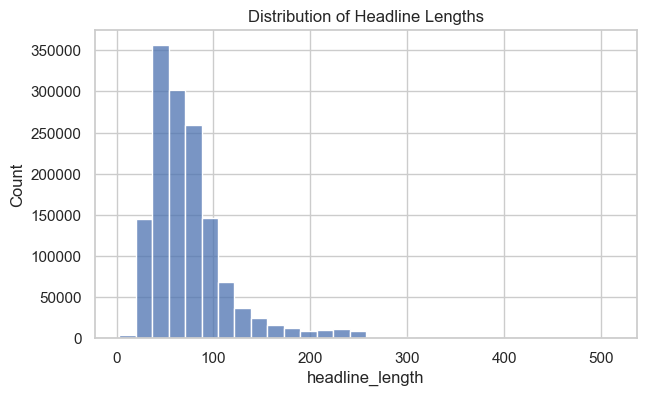


--- Publisher Frequency (Top 20) ---
publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


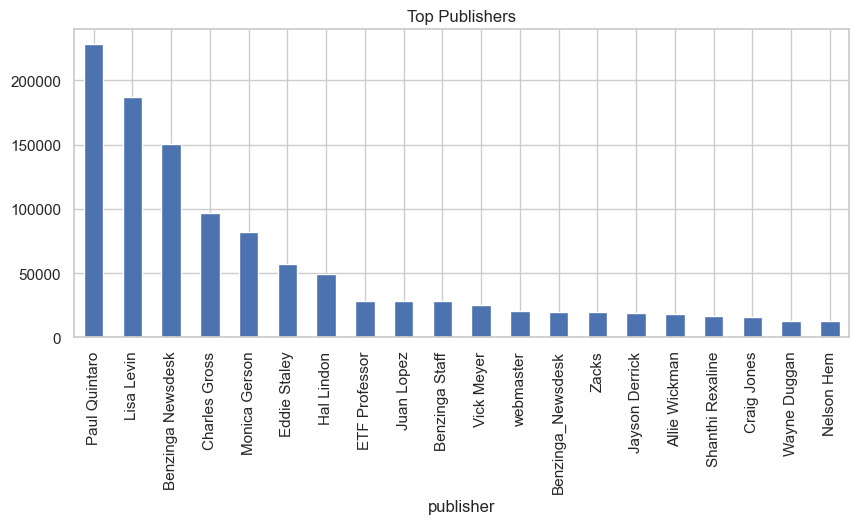

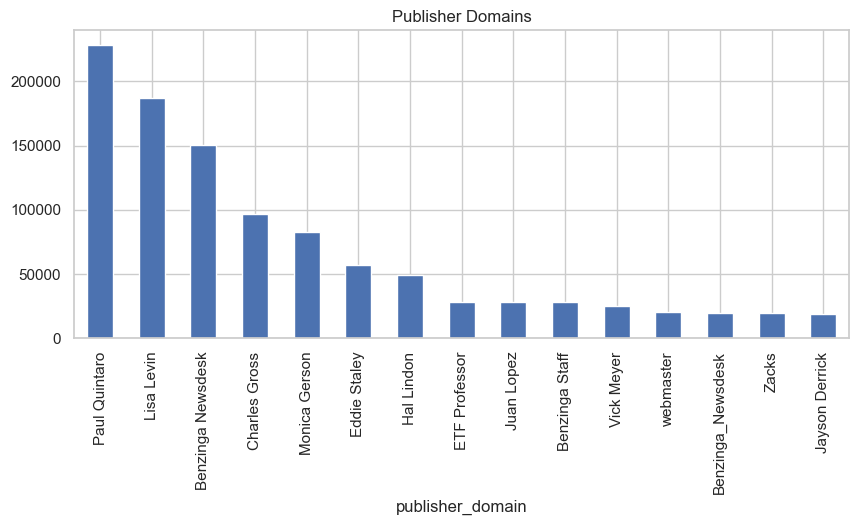

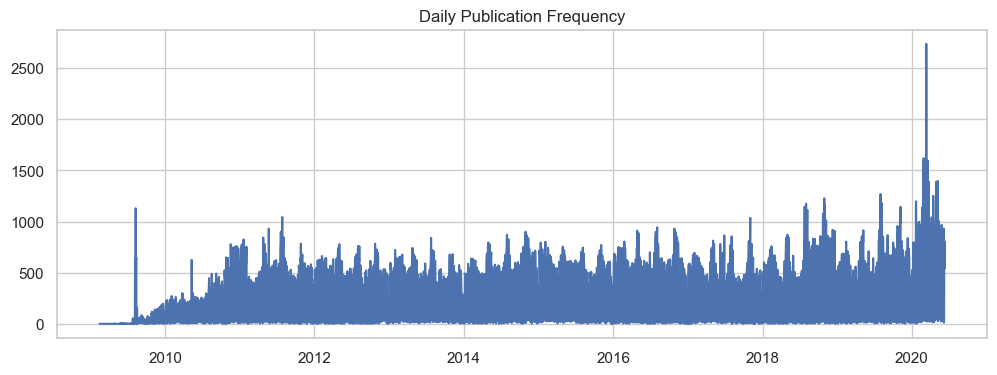

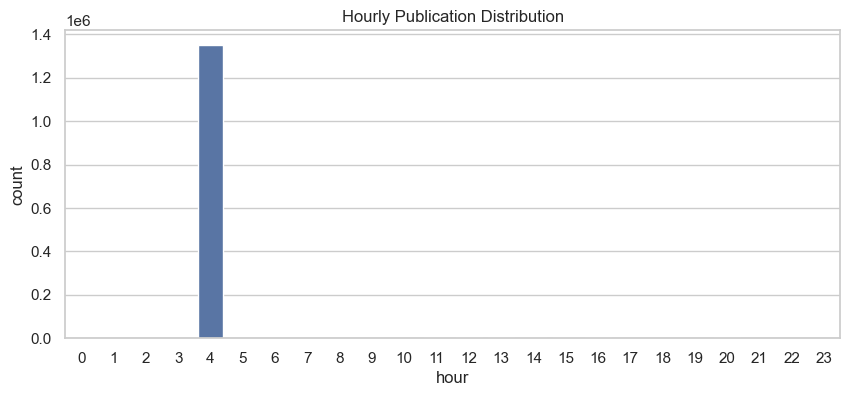

C:\Users\Jose\AppData\Local\Temp\ipykernel_20756\2837937150.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=sample['category'], palette="viridis")


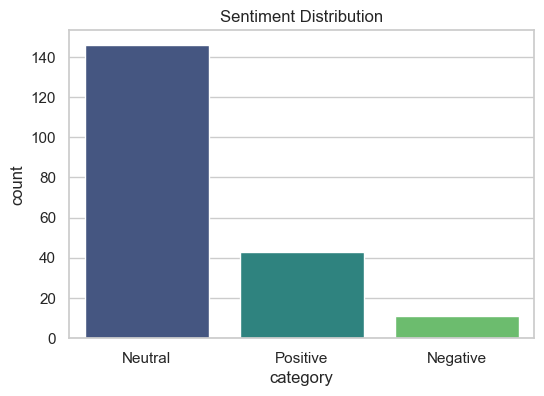

                                                                    headline  \
date                                                                           
2020-06-05 14:30:54+00:00            Stocks That Hit 52-Week Highs On Friday   
2020-06-03 14:45:20+00:00         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26 08:30:07+00:00                      71 Biggest Movers From Friday   
2020-05-22 16:45:06+00:00       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22 15:38:59+00:00  B of A Securities Maintains Neutral on Agilent...   

                                                                    keywords  
date                                                                          
2020-06-05 14:30:54+00:00                    [Friday, Stocks, 52-Week Highs]  
2020-06-03 14:45:20+00:00                 [Wednesday, Stocks, 52-Week Highs]  
2020-05-26 08:30:07+00:00        [Friday, Biggest Movers, 71 Biggest Movers]  
2020-05-22 16:45:06+00:00  [Mid-Day Session,

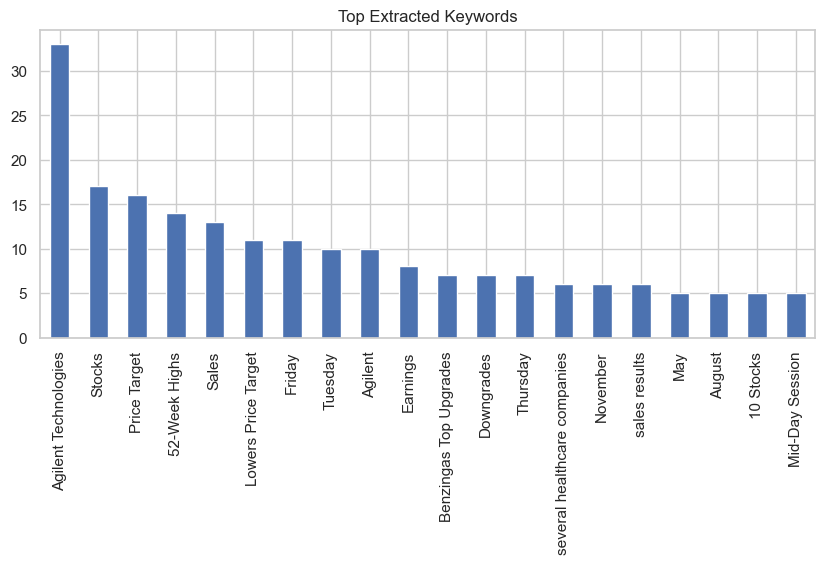


==== Modular EDA + NLP Complete ====


In [13]:
# ============================================================
# MAIN PIPELINE
# ============================================================

df = load_dataset("../data/raw_analyst_ratings.csv")
df = clean_headlines(df)
df = prepare_dates(df)

# --- Descriptive Statistics ---
headline_statistics(df)
publisher_statistics(df)
publisher_domain_analysis(df)

# --- Time Series ---
publication_trends(df)

# --- Sentiment Analysis ---
sent_sample = apply_sentiment(df)
plot_sentiment_distribution(sent_sample)

# --- Keyword Extraction ---
kw_sample = add_keywords(df)
print(kw_sample[['headline', 'keywords']].head())

keyword_frequency(kw_sample)

print("\n==== Modular EDA + NLP Complete ====")
